# Learning from Imbalanced Data - Part D

## Tutorial support notebook


This notebook supports the slides of the tutorial on "Learning from Imbalanced Data" that was presented in the 14th International Conference on Information, Intelligence, Systems and Applications (IISA 2023), University of Thessaly, Volos, Greece.

This part demonstrates the usage of Boosting and Bagging in oversampling and undersampling. In particular, we will examine the following methods:
* SMOTEBoost
* RUSBoost
* SMOTEBagging


**Author: Leonidas Akritidis**

**Last update: 10/07/2023**


In [1]:
import numpy as np
import pandas as pd
import time
import math
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Used for creating training and test sets
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Ensemble Classification models
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.cluster import KMeans

# Imbalanced data oversamplers and Undersamplers
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import ClusterCentroids

from imblearn.over_sampling import KMeansSMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import ADASYN

# Evaluation Measures
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, classification_report

import random

seed=42
num_samples=1000
imbalance_ratio = [0.95,0.05]
num_classes=len(imbalance_ratio)
oversampling_ratio=1.0

random.seed(seed)
np.random.seed(seed)



## Creating an imbalanced dataset

The experiments will be based on a synthetic dataset generated with scikit-learn's `make_classification` function. We will build a test dataset with `num_samples` two-dimensional examples and `len(imbalance_ratio)` classes. The `imbalance_ratio` determines the imbalance between the majority and the minorty class/es.


<AxesSubplot:>

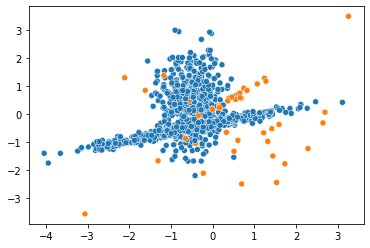

In [2]:
dataset = make_classification(n_samples=num_samples, n_features=2, n_clusters_per_class=2,
                              n_classes=num_classes, weights=imbalance_ratio, flip_y=0, class_sep=0.5,
                              n_informative=2, n_redundant=0, n_repeated=0, random_state=seed)

X = dataset[0]
y = dataset[1]

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, legend=False)


Print the distribution of samples in the dataset classes:

In [3]:
print("Class Distribution:")

for k in range(num_classes):
    print("Class", k, ":", len(y[y==k]), "samples")


Class Distribution:
Class 0 : 950 samples
Class 1 : 50 samples


We prepare the dataset for classification. We split it into a training and a test set in a ratio $4:1$; in other words, 80% of the original data will be used for training, and 20% will be used for testing. Stratifying by the target variable guarantees that the distributions of the dataset classes will be (about) the same in the training and test sets.


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)


Print and plot the distribution of samples in the classes of the test set:

Class 0 : 190 samples
Class 1 : 10 samples


Text(0.5, 1.0, 'Class distribution in the test set\n')

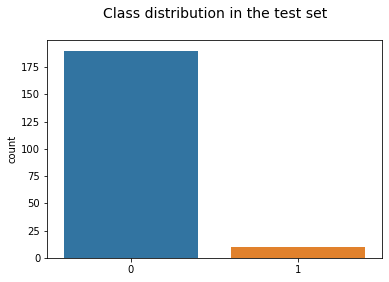

In [5]:
for k in range(num_classes):
    print("Class", k, ":", len(y_test[y_test==k]), "samples")

sns.countplot(x=y_test)
plt.title('Class distribution in the test set\n', fontsize=14)


## Classification with ensemble models


`plot_decision_regions_2D()`: The following function plots the dataset and the decision boundaries that are determined by each classifier.


In [6]:
def plot_decision_regions_2D(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 'o', 'o', 'o', 's', 'v', '^')
    colors = ('#1f77b4', '#ff7f0e', 'red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    
    # meshgrid: Return coordinate matrices from coordinate vectors. More specifically, we make N-D coordinate arrays
    # for vectorized evaluations of N-D scalar/vector fields over N-D grids, given one-dimensional coordinate arrays.
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))

    # ravel: Return a contiguous flattened array.
    # T: the transpose matrix
    X_test_in = np.array([xx1.ravel(), xx2.ravel()]).T
    # print(X_test)

    Z = classifier.predict(X_test_in)
    Z = Z.reshape(xx1.shape)

    plt.contourf(xx1, xx2, Z, alpha=0.15, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='white')


`TrainTestModel()`: A parametric function that trains and tests a classifier.


In [7]:
def TrainTestModel(train_X, test_X, train_y, test_y, mdl, res, desc):

        t0 = time.time()
        print("Training", mdl + "...\t", end="", flush=True)

        clf = models[mdl]
        clf.fit(train_X, train_y)

        print("  (%5.3f sec). \t" % (time.time() - t0), end="", flush=True)

        y_predicted = clf.predict(test_X)

        acc = accuracy_score(test_y, y_predicted)
        bacc = balanced_accuracy_score(test_y, y_predicted)

        if num_classes == 2:
            fpr, tpr, thresholds = roc_curve(test_y, y_predicted)
            auc_m = auc(fpr, tpr)
        else:
            auc_m = bacc

        print("Accuracy=%5.4f" % acc, "\tBalanced Accuracy=%5.4f"% bacc, "\tAUC=%5.4f" % auc_m, flush=True)

        res.append([ mdl, desc, acc, bacc ])

        X_stacked = np.vstack((train_X, test_X))
        Y_stacked = np.hstack((train_y, test_y))

        plot_decision_regions_2D(X_stacked, Y_stacked, clf)
        plt.xlabel("x0")
        plt.ylabel("x1")
        plt.title(mdl + " (Accuracy: " + (str)(round(acc, 3)) + ", AUC: " + (str)(round(auc_m, 3)) + ")")
        plt.legend(loc='upper left')


## Experiments

The experiments in this notebook are organized in phases:
* Phase 1: Train & test the ensemble classifiers on the original, imbalanced dataset.
* Phase 2: First perform undersampling of the majority class, then train & test the ensemble classifiers on the balanced dataset.
* Phase 3: First perform oversampling of the minority class, then train & test the ensemble classifiers on the balanced dataset.
* Phase 4: Resampling during Bagging: Perform oversampling and/or undersampling at each training round of the learners of the `BalancedBaggingClassifier` (SMOTEBagging falls into this category).
* Phase 5: Resampling during Boosting: Perform oversampling and/or undersampling at each training round of AdaBoost (RUSBoost and SMOTEBoost fall into this category).

We will use two simple ensemble models to perform classification:
 * **BaggingClassifier**: A typical Random Forest with 100 estimators, and
 * **AdaBoost** with 100 estimators and without restriction in the depth and the features. 
 

### Weak Model

Each ensemble classification model is based on a set of weak learners. Here we determine a weak learner to be a Decision Tree specificied as follows:


In [8]:
weak_model = DecisionTreeClassifier(criterion='gini', max_depth=None, max_features=None, random_state=seed)


### Ensemble classifiers

In [9]:
Results = []
dimensions = X_train.shape[1]
max_feat = math.sqrt(dimensions) // dimensions + 1

models = {
    "Bagging": BaggingClassifier(base_estimator=weak_model, n_estimators=100, max_features=max_feat, random_state=seed),
    "AdaBoost": AdaBoostClassifier(base_estimator=weak_model, n_estimators=100, algorithm='SAMME.R', random_state=seed)
}


### Oversamplers and Undersamplers

Initially we setup the oversampling and undersampling algorithm. For each algorithm, 6 techniques are created by utilizing a fluctuating imbalance ratio (`sampling_strategy`). In the following code, this parameter ranges from $0.05$ to $1.0$ by taking steps of $0.19$.


In [10]:
# Undersampling techniques: A list of tuples of three elements: [ (Method Description, Imbalance Ratio, Algorithm Object) ]
step = 0.19
alpha = round(imbalance_ratio[1] / imbalance_ratio[0], 2)
clusterer = KMeans(n_clusters=8, init='random', random_state=seed)

undersamplers = []

lst = [ ("RUS-" + str(int(imb_ratio*100)), imb_ratio, RandomUnderSampler(sampling_strategy=imb_ratio, replacement=True, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
undersamplers.extend(lst)

lst = [ ("NM1-" + str(int(imb_ratio*100)), imb_ratio, NearMiss(version=1, sampling_strategy=imb_ratio, n_neighbors=5)) for imb_ratio in np.arange(alpha, 1.01, step) ]
undersamplers.extend(lst)

lst = [ ("NM2-" + str(int(imb_ratio*100)), imb_ratio, NearMiss(version=2, sampling_strategy=imb_ratio, n_neighbors=5)) for imb_ratio in np.arange(alpha, 1.01, step) ]
undersamplers.extend(lst)

lst = [ ("NM3-" + str(int(imb_ratio*100)), imb_ratio, NearMiss(version=3, sampling_strategy=imb_ratio, n_neighbors=5)) for imb_ratio in np.arange(alpha, 1.01, step) ]
undersamplers.extend(lst)

lst = [ ("CLUS-" + str(int(imb_ratio*100)), imb_ratio, ClusterCentroids(estimator=clusterer, sampling_strategy=imb_ratio, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
undersamplers.extend(lst)
# print(undersamplers)


# Oversampling techniques: A list of tuples of three elements: [ (Method Description, Imbalance Ratio, Algorithm Object) ]
oversamplers = []

lst = [ ("ROS-" + str(int(imb_ratio*100)), imb_ratio, RandomOverSampler(sampling_strategy=imb_ratio, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
oversamplers.extend(lst)

lst = [ ("SMOTE-" + str(int(imb_ratio*100)), imb_ratio, SMOTE(sampling_strategy=imb_ratio, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
oversamplers.extend(lst)

lst = [ ("BORSMOTE-" + str(int(imb_ratio*100)), imb_ratio, BorderlineSMOTE(sampling_strategy=imb_ratio, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
oversamplers.extend(lst)

lst = [ ("SVMSMOTE-" + str(int(imb_ratio*100)), imb_ratio, SVMSMOTE(sampling_strategy=imb_ratio, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
oversamplers.extend(lst)

lst = [ ("CLUSMOTE-" + str(int(imb_ratio*100)), imb_ratio, KMeansSMOTE(sampling_strategy=imb_ratio, cluster_balance_threshold=0.01, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
oversamplers.extend(lst)

lst = [ ("ADASYN-" + str(int(imb_ratio*100)), imb_ratio, ADASYN(sampling_strategy=imb_ratio, random_state=seed)) for imb_ratio in np.arange(alpha, 1.01, step) ]
oversamplers.extend(lst)
#print(oversamplers)


### Phase 1: Ensemble Classifiers on the original dataset

Here we train & test the ensemble classifiers on the original, imbalanced dataset.


Training Bagging...	  (0.090 sec). 	Accuracy=0.9600 	Balanced Accuracy=0.6474 	AUC=0.6474
Training AdaBoost...	  (0.004 sec). 	Accuracy=0.9600 	Balanced Accuracy=0.6947 	AUC=0.6947


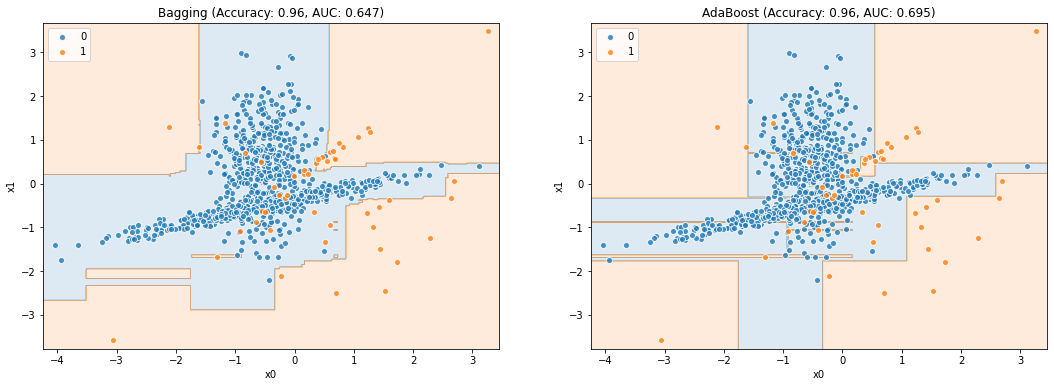

In [11]:
fig = plt.figure(figsize=(18, 6))

itr = 0
for model in models:
    itr = itr + 1
    plt.subplot(1, 2, itr)
    TrainTestModel(X_train, X_test, y_train, y_test, model, Results, "Original data")

plt.subplots_adjust(hspace=0.25)


### Phases 2 & 3: Ensemble Classifiers on the original dataset

We initially perform undersampling or oversampling and then we train & test the ensemble classifiers on the balanced dataset.


In [12]:
from tqdm.notebook import tqdm

# Phase 2
for U in tqdm(undersamplers):
    try:
        X_res_train, y_res_train = U[2].fit_resample(X_train, y_train)
    except:
        X_res_train = X_train
        y_res_train = y_train

    for mdl in models:
        clf = models[mdl]
        clf.fit(X_res_train, y_res_train)

        y_predicted = clf.predict(X_test)

        acc = accuracy_score(y_test, y_predicted)
        bacc = balanced_accuracy_score(y_test, y_predicted)

        scenario = "First " + U[0] + "- then " + mdl
        Results.append([ scenario, mdl, acc, bacc ])


  0%|          | 0/30 [00:00<?, ?it/s]

In [13]:
# Phase 3
for O in tqdm(oversamplers):
    try:
        X_res_train, y_res_train = O[2].fit_resample(X_train, y_train)
    except:
        X_res_train = X_train
        y_res_train = y_train

    for mdl in models:
        clf = models[mdl]
        clf.fit(X_res_train, y_res_train)

        y_predicted = clf.predict(X_test)

        acc = accuracy_score(y_test, y_predicted)
        bacc = balanced_accuracy_score(y_test, y_predicted)

        scenario = "First " + O[0] + "- then " + mdl
        Results.append([ scenario, mdl, acc, bacc ])


  0%|          | 0/36 [00:00<?, ?it/s]

### Phase 4: Resampling during Bagging

Bagging (Bootstrap Aggregation) is a popular ensemble learning method for improving the predictive performance of a model.
This technique reduces the variance within a noisy dataset. In Bagging, a random sample of data from the training set is selected with replacement (namely, the sample can be selected multiple times).

After several data samples have been selected, a group of weak models are trained independently. The final decision of the classifier is obtained by examining the majority of the decisions of all weak learners.


In [14]:
for U in tqdm(undersamplers):
    X_res_train = X_train.copy()
    y_res_train = y_train.copy()

    bbc = BalancedBaggingClassifier(sampler=U[2], estimator=weak_model, n_estimators=100,
                                    max_features=max_feat, random_state=seed)

    bbc.fit(X_res_train, y_res_train)
    y_pred = bbc.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)

    scenario = "BalancedBagging & " + U[0]
    Results.append([ scenario, "BalancedBaggingClassifier", acc, bacc ])

for O in tqdm(oversamplers):
    X_res_train = X_train.copy()
    y_res_train = y_train.copy()

    bbc = BalancedBaggingClassifier(sampler=O[2], estimator=weak_model, n_estimators=100,
                                    max_features=max_feat, random_state=seed)

    bbc.fit(X_res_train, y_res_train)
    y_pred = bbc.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)

    scenario = "BalancedBagging & " + O[0]

    Results.append([ scenario, "BalancedBaggingClassifier", acc, bacc ])


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

### Phase 5: Resampling during Boosting

Boosting is a popular learning method for improving the predictive performance of a model. It converts multiple weak learners (e.g. decision tree stumps) into a single strong learning model (e.g. a deep decision tree).

Initially, AdaBoost assigns equal weights to all training examples. This data is fed onto the first model which outputs its prediction for each example. Then, it increases the weight of the misclassified examples with a larger error. It also assigns a weight based on model performance. A model that produces good predictions will have a stringer impact on the final decision. In the sequel, AdaBoost passes the weighted data to the next classifier. These steps are repeated until the error falls under a certain threshold.


We will only include RUSBoost in this phase.


In [15]:
for imb_ratio in np.arange(alpha + step, 1.01, step):
    X_res_train = X_train.copy()
    y_res_train = y_train.copy()

    rusboost = RUSBoostClassifier(base_estimator=weak_model, n_estimators=100, algorithm='SAMME.R',
                                  sampling_strategy=imb_ratio, replacement=False, random_state=None)

    rusboost.fit(X_res_train, y_res_train)
    y_pred = rusboost.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    bacc = balanced_accuracy_score(y_test, y_pred)

    scenario = "RUSBoost-" + str(imb_ratio)
    Results.append([ scenario, "RUSBoostClassifier", acc, bacc ])


### 20 best ensemble methods (in terms of mean accuracy and mean balanced accuracy accross all classifiers)

In [16]:
df_results = pd.DataFrame(Results, columns=['Scenario', 'Classifier', 'Accuracy', 'BalancedAccuracy'])
df_results.to_csv('ensemble_results.csv')


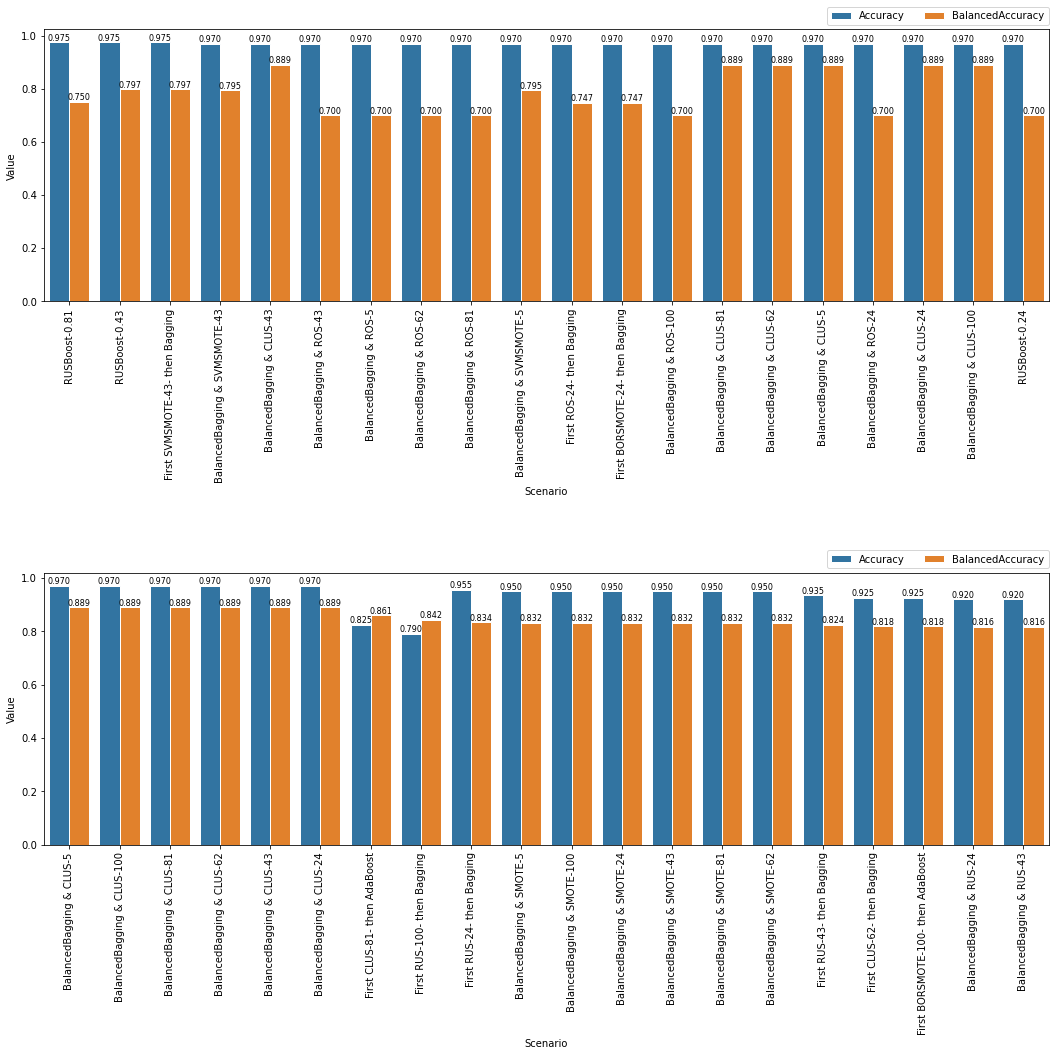

In [17]:
df = pd.read_csv('ensemble_results.csv')

fig = plt.figure(figsize=(18, 15))

# Plot the 20 best hybrid sampling scenario (in terms of accuracy)
# df_top20_acc = df.sort_values('Accuracy', ascending=False)
df_best = df.groupby('Scenario', as_index=False).mean().sort_values('Accuracy', ascending=False).head(20)
df_best = df_best.melt(id_vars=['Scenario'], value_vars=['Accuracy', 'BalancedAccuracy']).rename(columns=str.title)
df_best = df_best.sort_values(['Variable', 'Value'], ascending=[True, False])

plt.subplot(2, 1, 1)
ax = sns.barplot(data=df_best, x='Scenario', y='Value', hue='Variable', hue_order=['Accuracy', 'BalancedAccuracy'], edgecolor='white')
plt.legend(bbox_to_anchor=(1, 1.05), loc='right', borderaxespad=0, ncol=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', fontsize=8)


# Plot the 20 best hybrid sampling scenario (in terms of balanced accuracy)
df_best = df.groupby('Scenario', as_index=False).mean().sort_values('BalancedAccuracy', ascending=False).head(20)
df_best = df_best.melt(id_vars=['Scenario'], value_vars=['Accuracy', 'BalancedAccuracy']).rename(columns=str.title)
df_best = df_best.sort_values(['Variable', 'Value'], ascending=[False, False])

plt.subplot(2, 1, 2)
ax = sns.barplot(data=df_best, x='Scenario', y='Value', hue='Variable', hue_order=['Accuracy', 'BalancedAccuracy'], edgecolor='white')
plt.legend(bbox_to_anchor=(1, 1.05), loc='right', borderaxespad=0, ncol=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for i in ax.containers:
    ax.bar_label(i, fmt='%.3f', fontsize=8)


plt.subplots_adjust(hspace=1.0)
